# Stars or Storyline: How Actor Fame and Sentiment Trajectories Shape a Movie's Critical Success

# 0. Introduction

In the world of cinema, the question of what makes a movie successful remains complex and multi-faceted. Is it the star power of its cast, or does a captivating storyline hold more sway over an audience’s perception? Our project seeks to dissect these influences to understand what contributes more to a movie's critical success. We believe that the key elements lie in both the fame of the actors involved and the emotional journey crafted within the plot. What factors influence the most to predict the success of a movie?

Our approach explores two primary factors: actor fame and the sentiment trajectory of the movie plot. Using sentiment analysis on plot summaries, we examine the emotional arc of each story, uncovering patterns in tone and intensity. In parallel, we perform social network analysis to evaluate the influence of an actor’s connections and prominence within the industry.

In this results notebook, we showcase the different methods considered, the results obtained, the reasoning behind each decision, and additional reflections. Each section highlights our approach, the key insights derived, and the practical choices made along the way. This notebook consolidates our main findings, while the core logic is implemented in external scripts that we call from here.

Our ultimate goal is to provide a nuanced perspective on the elements that contribute to a movie’s success, examining whether a compelling emotional arc or the presence of influential actors holds more weight in capturing an audience’s approval.



# 1. Data Cleaning and Preprocessing

### 1.1 Clean the Datasets

In [1]:
# Import necessary libraries
import os
import pandas as pd
from matplotlib import pyplot as plt

# Import the cleaning functions from cleaning.py located in 'tests/Data Cleaning and Preprocessing'
from tests.Data_Cleaning_and_Preprocessing.cleaning import (
    clean_tvtropes_clusters,
    clean_name_clusters,
    clean_character_metadata,
    clean_plot_summaries,
    clean_movie_metadata
)

# Define the data directory
data_directory = os.path.join(os.getcwd(), 'src', 'data')

# Call each cleaning function and save the cleaned data as DataFrames
tvtropes_df = clean_tvtropes_clusters(data_directory)
name_clusters_df = clean_name_clusters(data_directory)
character_metadata_df = clean_character_metadata(data_directory)
plot_summaries_df = clean_plot_summaries(data_directory)
movie_metadata_df = clean_movie_metadata(data_directory)

# Display the first few rows of each DataFrame to verify cleaning
print("TV Tropes Clusters:")
display(tvtropes_df.head())

print("Name Clusters:")
display(name_clusters_df.head())

print("Character Metadata:")
display(character_metadata_df.head())

print("Plot Summaries:")
display(plot_summaries_df.head())

print("Movie Metadata:")
display(movie_metadata_df.head())


# Save the cleaned DataFrames to CSV files in the main 'data' directory with error handling for encoding
tvtropes_df.to_csv(os.path.join('data', 'tvtropes_cleaned.csv'), index=False, encoding='utf-8', errors='replace')
name_clusters_df.to_csv(os.path.join('data', 'name_clusters_cleaned.csv'), index=False, encoding='utf-8', errors='replace')
character_metadata_df.to_csv(os.path.join('data', 'character_metadata_cleaned.csv'), index=False, encoding='utf-8', errors='replace')
plot_summaries_df.to_csv(os.path.join('data', 'plot_summaries_cleaned.csv'), index=False, encoding='utf-8', errors='replace')
movie_metadata_df.to_csv(os.path.join('data', 'movie_metadata_cleaned.csv'), index=False, encoding='utf-8', errors='replace')



TV Tropes Clusters:


,trope_name,character,movie,movie_id,actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


Name Clusters:


,name,cluster_id
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


Character Metadata:


,movie_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,"/m/0bgchxw, /m/0bgcj3x, /m/03wcfv7"
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,"/m/0jys3m, /m/0bgchn4, /m/0346l4"
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,"/m/0jys3g, /m/0bgchn_, /m/01vw26l"
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,"/m/02vchl6, /m/0bgchnq, /m/034hyc"
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,"/m/02vbb3r, /m/0bgchp9, /m/01y9xg"


Plot Summaries:


,movie_id,plot_summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


Movie Metadata:


,movie_id,freebase_id,movie_name,release_date,revenue,runtime,languages,countries,genres,countries_clean,genres_clean,languages_clean
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",English
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",United States of America,"Mystery, Biographical film, Drama, Crime Drama",English
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",Norway,"Crime Fiction, Drama",Norwegian
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",United Kingdom,"Thriller, Erotic thriller, Psychological thriller",English
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",Germany,Drama,German


OSError: [Errno 22] Invalid argument: 'data\\plot_summaries_cleaned.csv'

#### Explanation of Data Cleaning Functions in `cleaning.py`

##### 1. `clean_tvtropes_clusters`
- **Objective**: Clean the `tvtropes.clusters.txt` file.
- **Process**:
  - Parses the `details` field, which contains JSON-like data, to extract key fields such as `character`, `movie`, `movie_id`, and `actor`.
  - Converts this data into a cleaner format by organizing the extracted values into individual columns, making the dataset easier to work with.

##### 2. `clean_name_clusters`
- **Objective**: Clean the `name.clusters.txt` file.
- **Process**:
  - Loads the data and assigns column names (`name`, `cluster_id`) for clarity.
  - Checks for and removes any missing or redundant entries to ensure consistency.

##### 3. `clean_character_metadata`
- **Objective**: Clean the `character.metadata.tsv` file.
- **Process**:
  - Fixes misalignments where rows contain extra `Freebase` character columns, ensuring all rows have consistent structure.
  - Replaces `Unknown` with `NaN` for missing data, and assigns appropriate data types to columns like `actor_height` and `actor_age`.
  - Ensures realistic values in the `actor_age` column by converting negative values to positive and setting a maximum age limit.

##### 4. `clean_plot_summaries`
- **Objective**: Clean the `plot_summaries.txt` file.
- **Process**:
  - Loads the plot summaries dataset, verifies unique `movie_id`s, and checks for duplicates.
  - Prepares the plot summaries for further analysis by ensuring each summary is correctly linked to its respective movie ID.

##### 5. `clean_movie_metadata`
- **Objective**: Clean the `movie.metadata.tsv` file.
- **Process**:
  - Parses fields like `countries`, `genres`, and `languages` to extract human-readable values from dictionary-like entries.
  - Handles missing values for key columns such as `release_date`, `revenue`, and `runtime`.
  - Generates cleaned versions of `languages`, `countries`, and `genres` columns, creating a standardized format.


### 1.2 Adding Ratings

### 1.3 Adding missing Data


### 1.4 Master Dataset

# 2. Metric Selection and Preliminary Analysis

### 2.1 Definition of Sucess

To conduct any meaningful analysis of success, it’s crucial to first define what “success” actually means in the given context. Success is a multifaceted concept that can vary widely depending on goals, stakeholders, and industry standards. Without a clear definition, it’s challenging to identify the factors that contribute to success or measure their impact accurately.

Defining success requires selecting parameters that align with the unique objectives and context of the analysis. In the film industry, for instance, success could be measured by revenue, which speaks to a movie's commercial appeal, or by critical reviews, which reflect its artistic and cultural impact. However, factors like the size of the target audience and the specific market or country also shape these definitions. A blockbuster may achieve global success through widespread appeal and high box office revenue, whereas an independent film might be considered successful if it performs well locally, resonating strongly with a niche audience or in a particular country.

### 2.2 Preliminary Analysis

#### General

Having a comprehensive overview of our datasets is crucial to understanding their scope and dimensions. Visualizing the data can often spark new ideas, raise pertinent questions, and guide the direction of our analysis. By examining the general characteristics and distributions within our datasets, we can identify patterns, anomalies, and potential areas of interest that warrant further investigation. This initial exploration sets the foundation for more detailed and targeted analyses in subsequent sections.

In [ ]:
# Data preprocessing and analysis
movie_metadata_df['year'] = pd.to_datetime(movie_metadata_df['release_date'], errors='coerce').dt.year
df_cleaned = movie_metadata_df.dropna(subset=['year', 'revenue'])
df_cleaned['revenue'] = pd.to_numeric(df_cleaned['revenue'], errors='coerce')
df_cleaned = df_cleaned.dropna(subset=['revenue'])
revenue_stats = df_cleaned.groupby('year')['revenue'].agg(['mean', 'std', 'median', 'min', 'max'])

# Proportion of movies with box office revenue available
total_movies = movie_metadata_df.shape[0]
movies_with_revenue = movie_metadata_df['revenue'].notna().sum()
proportion_with_revenue = movies_with_revenue / total_movies

C:\Users\Pierre\AppData\Local\Temp\ipykernel_21872\2371286892.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['revenue'] = pd.to_numeric(df_cleaned['revenue'], errors='coerce')


### Revenue

The first factor to explore is revenue, as it is often a primary indicator of a movie’s commercial success.

By plotting the sum of movie revenues over time, we can get a sense of growth trends, but this analysis is biased due to a higher number of recent movies in the database. It’s unclear whether fewer movies were made in earlier years or if the dataset simply contains more recent entries. Additionally, this analysis doesn’t account for inflation, which affects the comparability of revenue figures across different time periods.

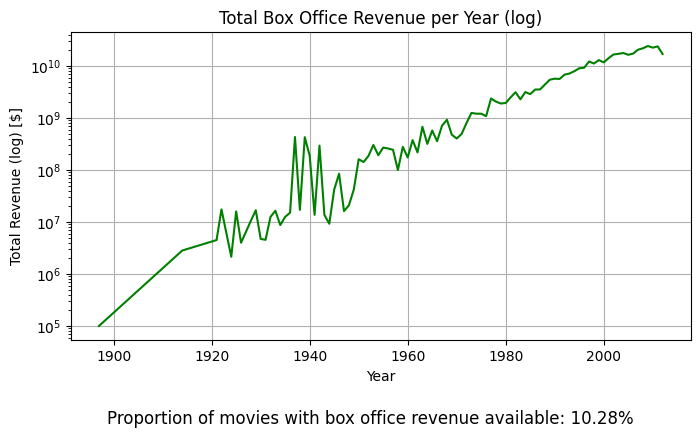

In [ ]:
# Plot: Total Box Office Revenue per Year
total_revenue_per_year = df_cleaned.groupby('year')['revenue'].sum()

plt.figure(figsize=(8, 4))
plt.plot(total_revenue_per_year.index, total_revenue_per_year.values, color='green')
plt.title('Total Box Office Revenue per Year (log)')
plt.xlabel('Year')
plt.ylabel('Total Revenue (log) [$]')
plt.yscale('log')  # Set y-axis to log scale
plt.grid(True)
# Display of available data %
plt.figtext(0.5, -0.1, f"Proportion of movies with box office revenue available: {proportion_with_revenue:.2%}", ha='center', fontsize=12)
plt.show()

By analyzing the mean revenue over time, we observe spikes in certain decades, notably the 1960s, 1970s, 2000s, and around 2012, despite an overall upward trend. When using the median instead of the mean, these spikes appear even more pronounced, indicating periods of exceptionally high revenue for certain movies. Adjusting for inflation would likely amplify these spikes further, suggesting that some decades represent peaks of heightened interest or popularity in the film industry.

The variance in movie revenues has not remained constant over time, indicating a broader range of outcomes in recent years. This suggests an increasing variety of both high-grossing hits and low-performing flops, reflecting a more polarized landscape in the film industry. Over time, movies have become more variable in their success, likely due to factors like larger budgets for blockbusters, a growing number of independent films, and shifting audience preferences.

Revenue data shows distinct spikes of interest in movies across different decades, indicating varying peaks of popularity over time. However, relying on revenue alone to measure a movie’s success has limitations. Local successes in smaller countries with high popularity but lower revenue can be overlooked, and differences in purchasing power between rich and poor countries create disparities in revenue data. Additionally, without adjusting for inflation, revenue figures can misrepresent a movie’s true economic impact over time. Therefore, revenue alone is not a reliable indicator to fully explain a movie’s success. Other metrics should be considered for a more comprehensive understanding.

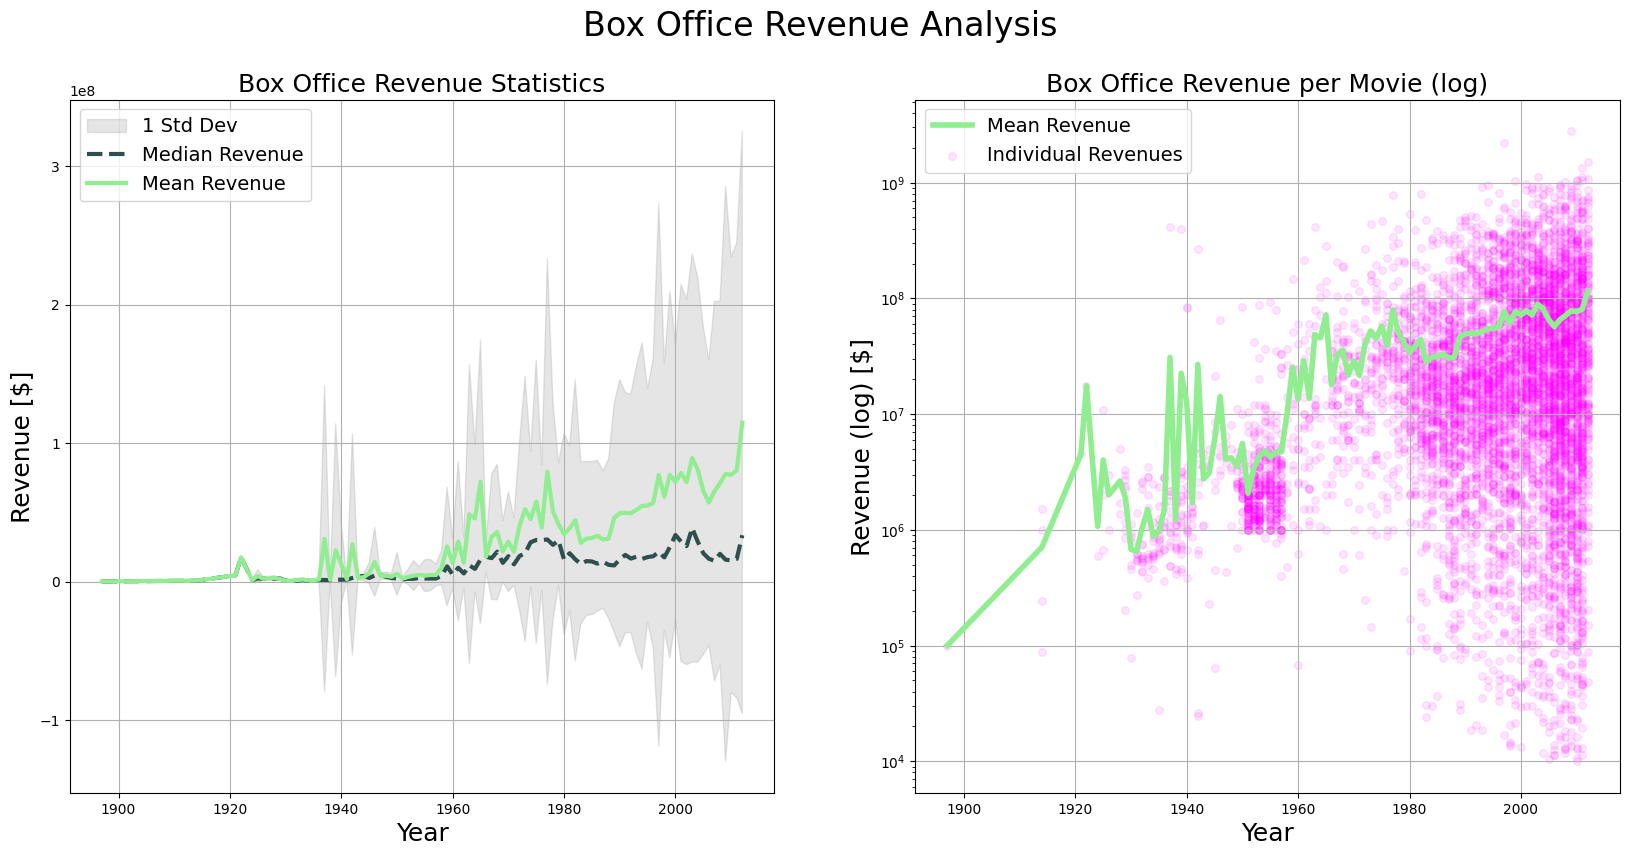

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 9))
# Main title
fig.suptitle('Box Office Revenue Analysis', fontsize=24)
# Plot 1
axes[0].fill_between(revenue_stats.index, revenue_stats['mean'] - revenue_stats['std'],
                     revenue_stats['mean'] + revenue_stats['std'], color='grey', alpha=0.2, label='1 Std Dev')
axes[0].plot(revenue_stats.index, revenue_stats['median'], label='Median Revenue', linestyle='--', color='darkslategray', linewidth=3)
axes[0].plot(revenue_stats.index, revenue_stats['mean'], label='Mean Revenue', color='lightgreen', linewidth=3)
axes[0].set_title('Box Office Revenue Statistics', fontsize=18)
axes[0].set_xlabel('Year', fontsize=18)
axes[0].set_ylabel('Revenue [$]', fontsize=18)
axes[0].legend(fontsize=14)
axes[0].grid(True)

# Plot 2
axes[1].plot(revenue_stats.index, revenue_stats['mean'], label='Mean Revenue', color='lightgreen', linewidth=4)
# axes[1].plot(revenue_stats.index, revenue_stats['min'], label='Min Revenue', linestyle=':', color='blue',linewidth=3)
# axes[1].plot(revenue_stats.index, revenue_stats['max'], label='Max Revenue', linestyle=':', color='red', linewidth=3)
axes[1].scatter(df_cleaned['year'], df_cleaned['revenue'], color='magenta', alpha=0.1, label='Individual Revenues', s=30)
axes[1].set_title('Box Office Revenue per Movie (log)', fontsize=18)
axes[1].set_xlabel('Year', fontsize=18)
axes[1].set_ylabel('Revenue (log) [$]', fontsize=18)
axes[1].set_yscale('log')  # Set y-axis to log scale
axes[1].legend(fontsize=14)
axes[1].grid(True)


plt.show()

#### Actors

Our hypothesis is that we might be able to correlate simple data on actors with their connections and prominence within the industry. For example, if we take the age of an actor, it seems more likely that the younger they started their career, the more connections they will have developed over time. Additionally, factors such as the number of movies an actor has participated in, the diversity of genres they have worked in, and their collaborations with other prominent actors could also be indicative of their influence and network within the industry.

By analyzing these variables, we aim to uncover patterns that highlight the significance of an actor's career trajectory and their impact on a movie's success. This analysis could provide valuable insights into how an actor's fame and industry connections contribute to the overall reception and performance of a film.

In [ ]:

# Calculate age statistics
#character_metadata_df['actor_age'] = pd.to_numeric(character_metadata_df['actor_age'], errors='coerce')
age_stats = character_metadata_df.groupby('release_date')['actor_age'].agg(['mean', 'std', 'median', 'min', 'max'])

plt.figure(figsize=(7, 4))
plt.plot(age_stats.index, age_stats['mean'], label='Mean Age', color='yellow')
plt.fill_between(age_stats.index, age_stats['mean'] - age_stats['std'],
                 age_stats['mean'] + age_stats['std'], color='grey', alpha=0.2, label='1 Std Dev')
plt.plot(age_stats.index, age_stats['median'], label='Median Age', linestyle='--', color='darkgrey')
plt.plot(age_stats.index, age_stats['min'], label='Min Age', linestyle=':', color='blue')
plt.plot(age_stats.index, age_stats['max'], label='Max Age', linestyle=':', color='red')
plt.title('Age Statistics of Actors Over the Years')
plt.xlabel('Year')
plt.ylabel('Age')
plt.legend()
plt.grid(True)
plt.show()

1
2
3
4
5
6
7
8


KeyboardInterrupt: 

In [ ]:
# df_simple_revenu = movie_metadata_df
# df_simple_revenu['release_date'] = pd.to_datetime(df_simple_revenu['release_date'], errors='coerce')
# df_simple_revenu['release_date'] = df_simple_revenu['release_date'].dt.year

# yearly_revenue_sum = df_simple_revenu.groupby('release_date')['revenue'].sum()
# yearly_revenue_mean = df_simple_revenu.groupby('release_date')['revenue'].mean()
# yearly_revenue_median = df_simple_revenu.groupby('release_date')['revenue'].median()

# import matplotlib.pyplot as plt

# # Graphe total revenu
# plt.figure(figsize=(10, 6))
# plt.plot(yearly_revenue_sum.index, yearly_revenue_sum.values, marker='o', linestyle='-')
# plt.title('Total Revenue by Year')
# plt.xlabel('Year')
# plt.ylabel('Total Revenue')
# plt.grid(True)
# plt.show()

# # Graphe Yearly Revenue Mean
# plt.figure(figsize=(10, 6))
# plt.plot(yearly_revenue_mean.index, yearly_revenue_mean.values, marker='o', linestyle='-')
# plt.title('Mean Revenue by Year')
# plt.xlabel('Year')
# plt.ylabel('Mean Revenue')
# plt.grid(True)
# plt.show()

# # Yearly Revenue Median
# plt.figure(figsize=(10, 6))
# plt.plot(yearly_revenue_median.index, yearly_revenue_median.values, marker='o', linestyle='-')
# plt.title('Median Revenue by Year')
# plt.xlabel('Year')
# plt.ylabel('Median Revenue')
# plt.grid(True)
# plt.show()

# # Individual Revenues
# plt.figure(figsize=(10, 6))
# plt.scatter(df_simple_revenu['release_date'], df_simple_revenu['revenue'], color='red', alpha=0.6, label='Individual Revenues')
# plt.title('Revenue by Year')
# plt.xlabel('Year')
# plt.ylabel('Revenue')
# plt.grid(True)
# plt.show()

Reviews are another crucial factor to consider when analyzing a movie’s performance or popularity. User reviews, critical ratings, and audience feedback can provide valuable insights into how well a movie resonates with its audience. Positive reviews often correlate with higher viewer engagement, word-of-mouth promotion, and overall success, both in box office earnings and long-term streaming or sales. Conversely, negative reviews can significantly impact a movie's reception, leading to lower viewership and reduced revenue. Incorporating review data into the analysis allows for a more comprehensive understanding of a movie's success, as it combines financial metrics with audience sentiment, providing a fuller picture of its overall impact in the entertainment industry.

............................................................................................
(to do when we have the data)

In [ ]:
### 2.3 Sucess Metric Selection

We define the success metric 

S = ratings * log(number of vote)

effectively combines both the quality and popularity of a movie into a single value. By multiplying the average rating with the logarithm of the number of votes, it ensures that movies with higher ratings and a significant number of votes are given appropriate weight. This metric is particularly useful because ratings tend to follow a Gaussian distribution, with most movies clustering around the middle, while the number of votes often follows a log-normal distribution. The logarithmic adjustment of vote count helps balance the influence of highly-voted movies without letting them disproportionately skew the results. Overall, this approach provides a fair and comprehensive evaluation of a movie's success, capturing both its quality and its widespread appeal.

# 3. Sentiment Analysis

### 3.1 Choice of Model

### 3.2 Sentence Segmentation & Sentiment Scoring

### 3.3 Planned Analysis (to do)

# 4. Network Analysis

### 4.1 Actor Network Visualization

### 4.2  Planned Analysis (to do)

# 5. Results and Interpretations (to do)